In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchmetrics.segmentation import MeanIoU

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.models.vgg import VGG
from torchvision import transforms
from torchmetrics.segmentation import MeanIoU
from tqdm import tqdm

### Part 2.1

In [3]:
def visualize_class_masks(mask_path, class_labels):
    mask_image = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)    
    mask = mask_image[:, :, 2] if len(mask_image.shape) == 3 else mask_image
    
    n_classes = len(class_labels)
    n_cols = 5
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten() if n_rows > 1 else axes
    
    for class_id, class_name in enumerate(class_labels):
        binary_mask = (mask == class_id).astype(np.uint8) * 255
        
        axes[class_id].imshow(binary_mask, cmap='gray')
        axes[class_id].set_title(class_name)
        axes[class_id].axis('off')
    
    for j in range(n_classes, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
class_labels = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", 
    "Pole", "Roadline", "Road", "Sidewalk", "Vegetation", 
    "Car", "Wall", "Traffic sign"
]

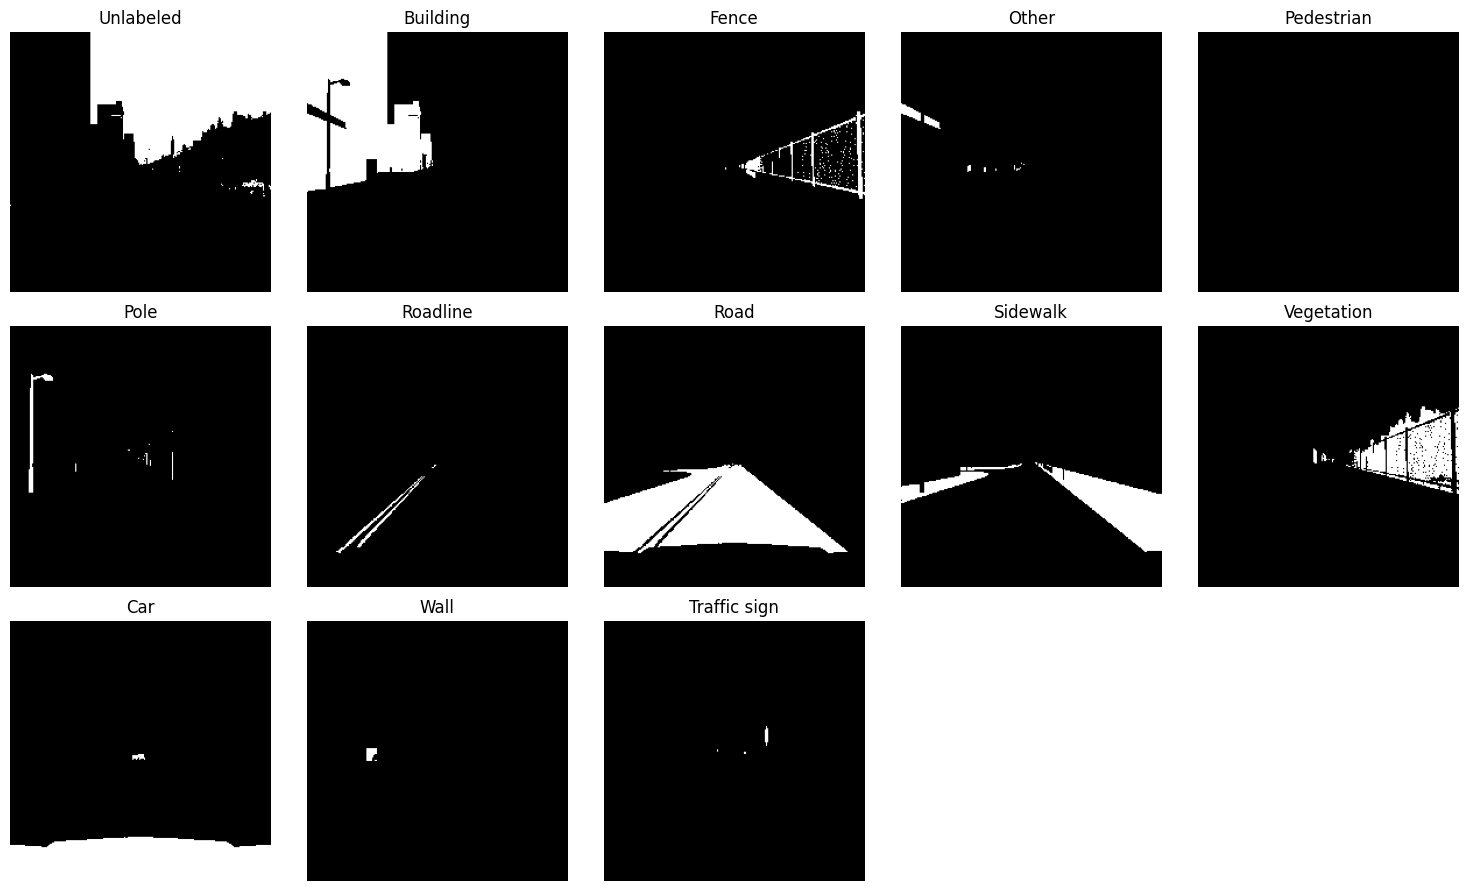

In [6]:
mask_image_path = "./dataset_224/train/labels/02_00_012.png"
visualize_class_masks(mask_image_path, class_labels)

image 02_00_000


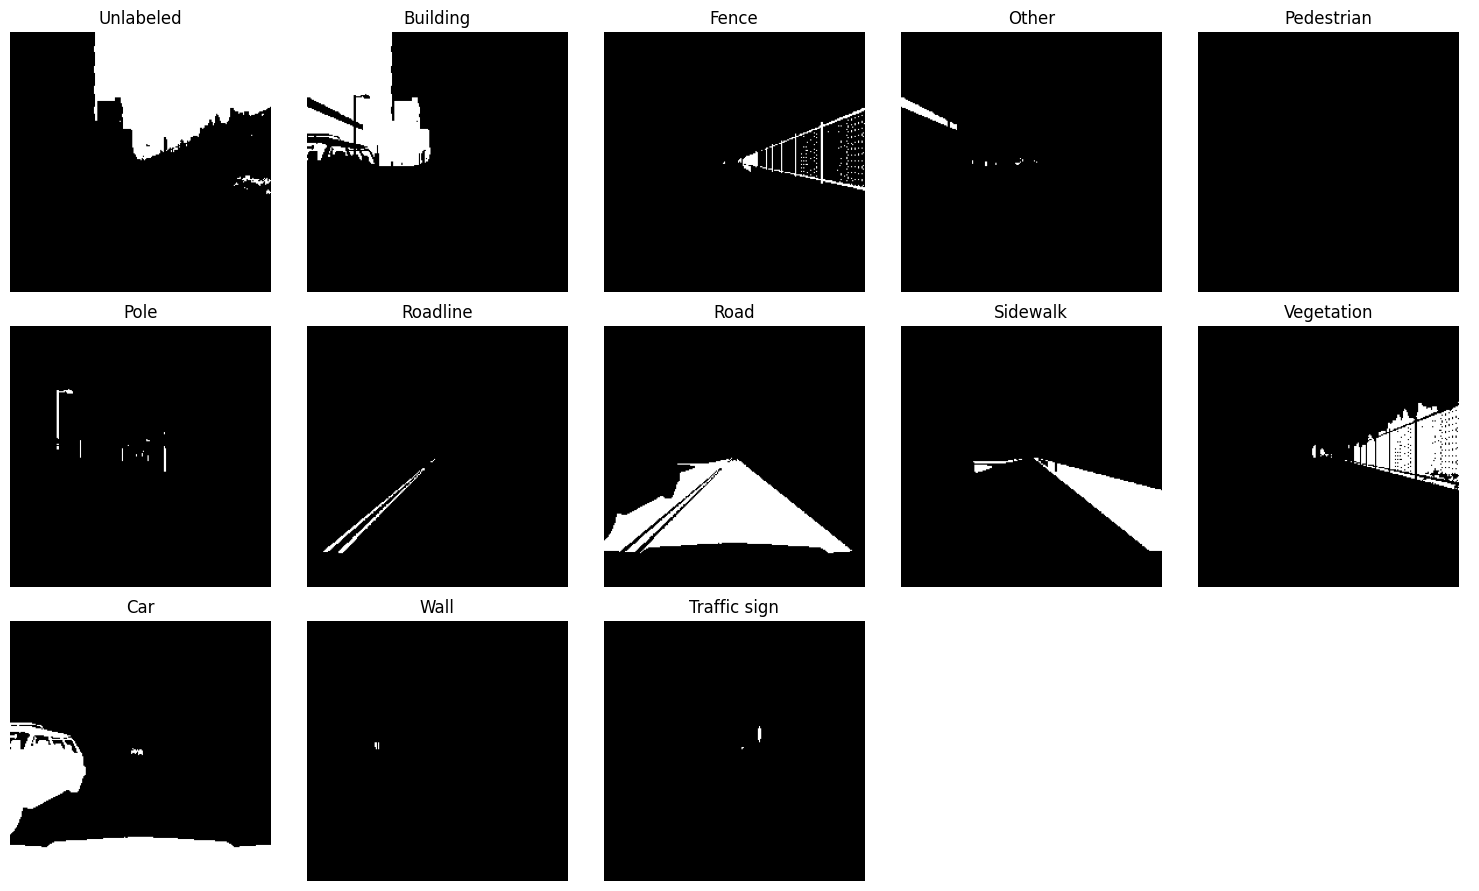

image 02_00_001


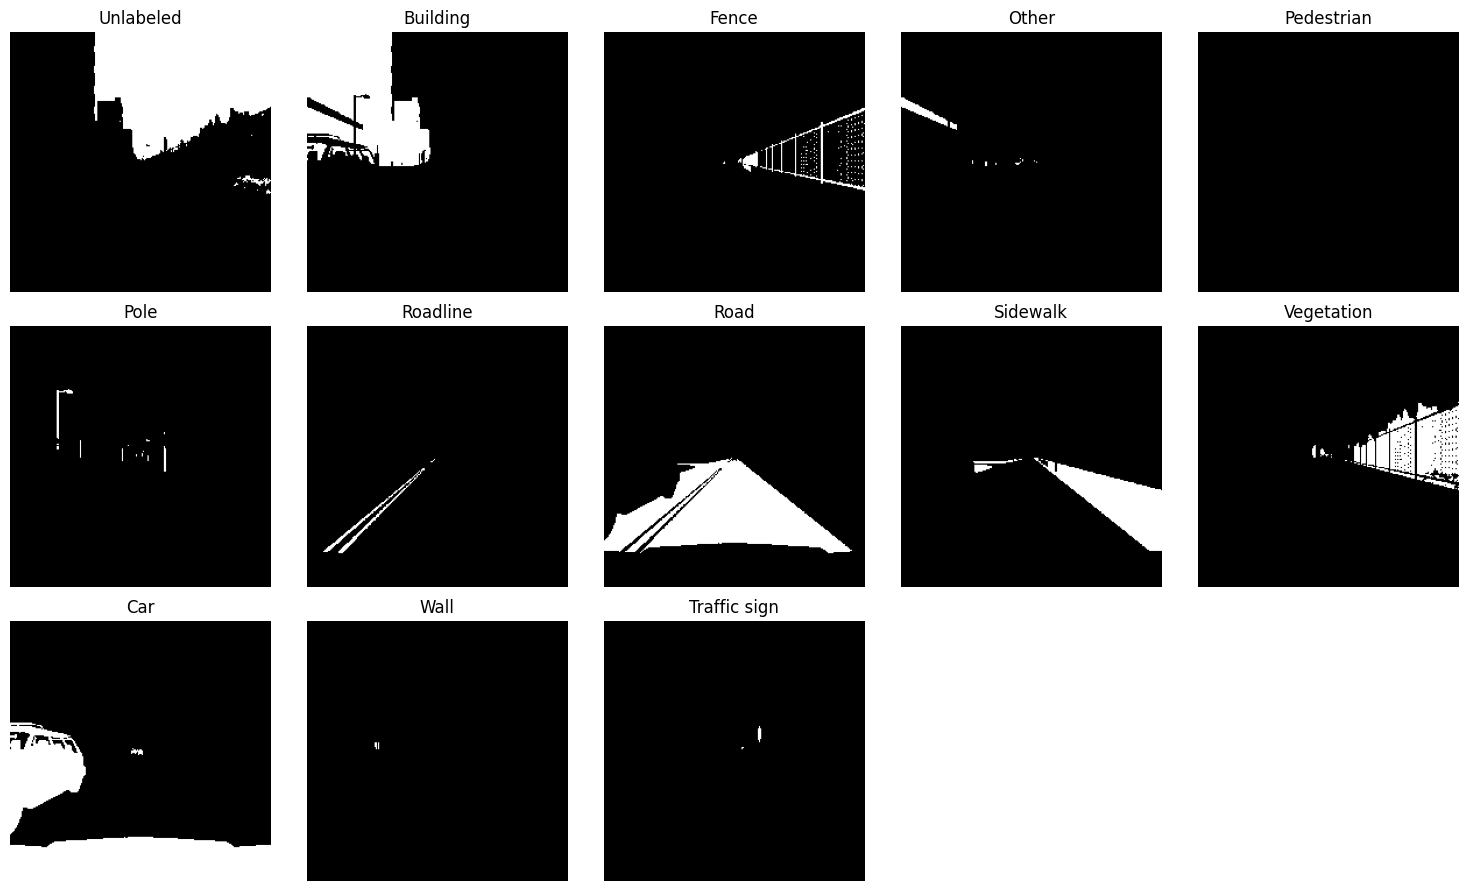

image 02_00_002


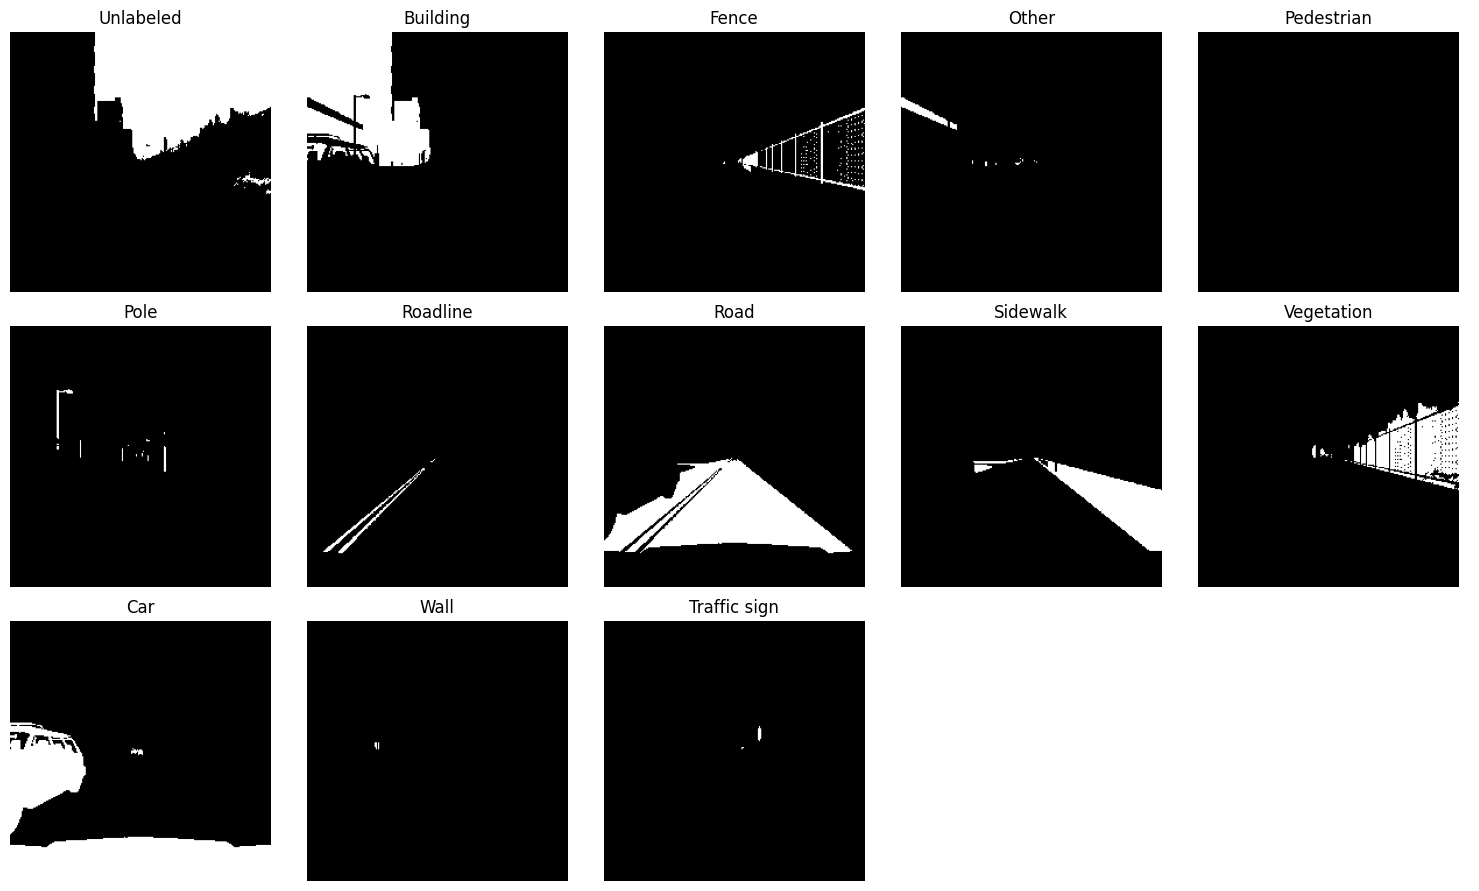

image 02_00_003


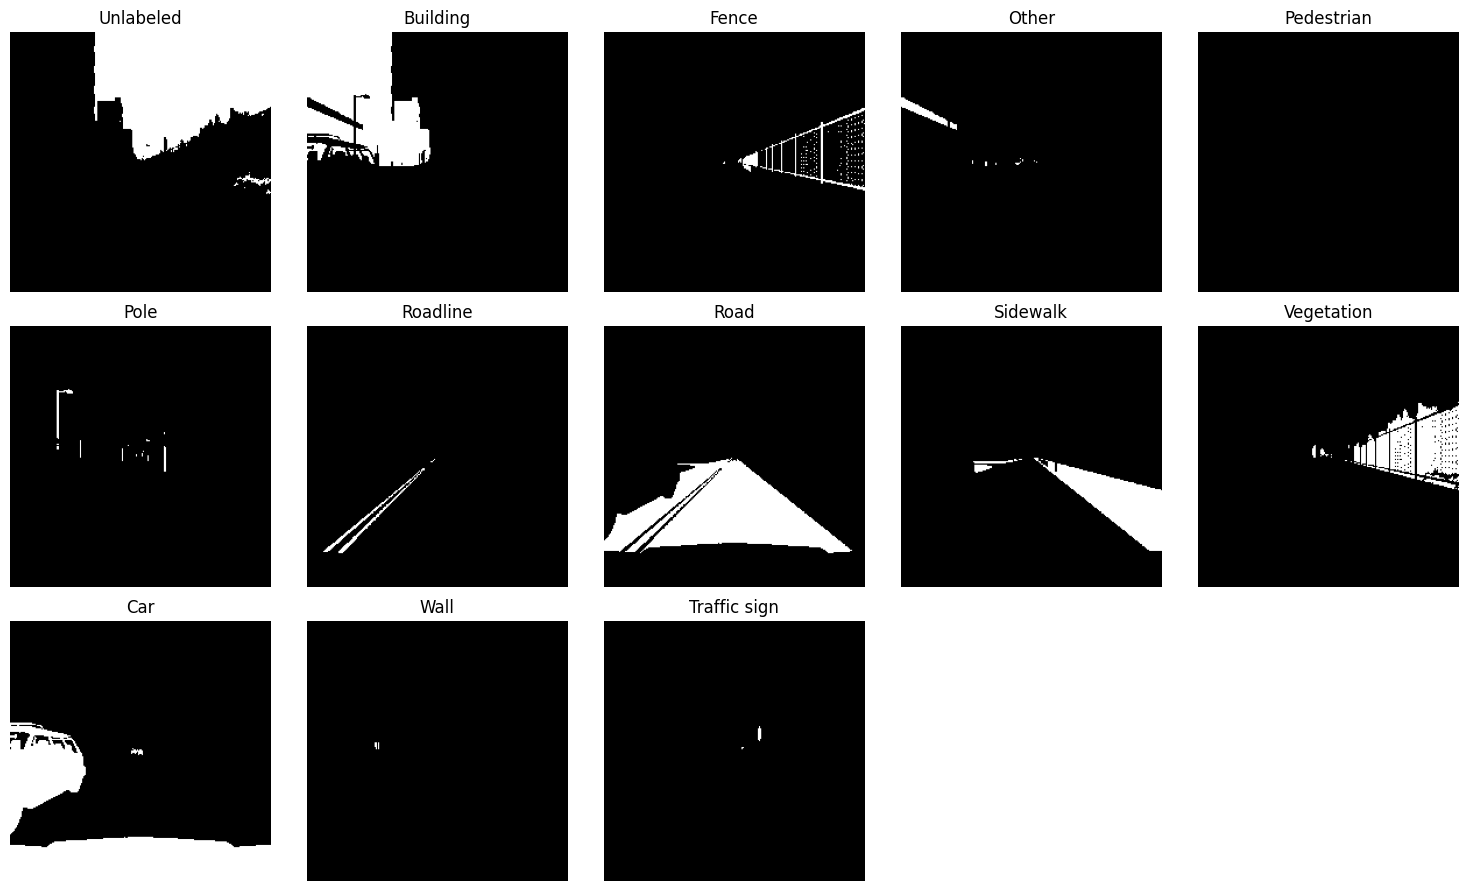

In [7]:
for i in range(4):
    mask_image_path = f"./dataset_224/train/labels/02_00_00{i}.png"
    print(f"image 02_00_00{i}")
    visualize_class_masks(mask_image_path, class_labels)

### 2.2

In [50]:
# Constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 13
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 25
IMG_SIZE = (224, 224)

In [51]:
# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert NumPy arrays to PIL Images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            # For mask, we only need to convert to tensor, not normalize
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

In [52]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [53]:
# VGG configuration
VGG_CONFIGS = {
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

VGG_RANGES = {
    'vgg16': [(0, 5), (5, 10), (10, 17), (17, 24), (24, 31)],
    'vgg19': [(0, 5), (5, 10), (10, 19), (19, 28), (28, 37)]
}

In [54]:
def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [55]:
class VGGBackbone(VGG):
    def __init__(self, model_name='vgg16', pretrained=True, requires_grad=True):
        super().__init__(make_layers(VGG_CONFIGS[model_name]))
        self.ranges = VGG_RANGES[model_name]

        if pretrained:
            exec(f"self.load_state_dict(models.{model_name}(pretrained=True).state_dict())")

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        del self.classifier

    def forward(self, x):
        features = {}
        for idx, (start, end) in enumerate(self.ranges):
            for layer in range(start, end):
                x = self.features[layer](x)
            features[f"x{idx+1}"] = x
        return features

In [56]:
class FCN(nn.Module):
    def __init__(self, backbone, n_classes, variant, freeze_backbone=True):
        super().__init__()
        self.backbone = backbone
        self.n_classes = n_classes
        self.variant = variant
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in backbone.parameters():
                param.requires_grad = False
            
        self.relu = nn.ReLU(inplace=True)
        
        # Upsampling layers
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.classifier = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        features = self.backbone(x)
        x5 = features['x5']  # 1/32 size
        x4 = features['x4']  # 1/16 size
        x3 = features['x3']  # 1/8 size
        
        if self.variant == "32s":
            # No skip connections
            score = self.bn1(self.relu(self.deconv1(x5)))
            score = self.bn2(self.relu(self.deconv2(score)))
            score = self.bn3(self.relu(self.deconv3(score)))
            score = self.bn4(self.relu(self.deconv4(score)))
            score = self.bn5(self.relu(self.deconv5(score)))
            
        elif self.variant == "16s":
            # Skip connection from pool4
            score = self.relu(self.deconv1(x5))
            score = self.bn1(score + x4)
            score = self.bn2(self.relu(self.deconv2(score)))
            score = self.bn3(self.relu(self.deconv3(score)))
            score = self.bn4(self.relu(self.deconv4(score)))
            score = self.bn5(self.relu(self.deconv5(score)))
            
        elif self.variant == "8s":
            # Skip connections from pool4 and pool3
            score = self.relu(self.deconv1(x5))
            score = self.bn1(score + x4)
            score = self.relu(self.deconv2(score))
            score = self.bn2(score + x3)
            score = self.bn3(self.relu(self.deconv3(score)))
            score = self.bn4(self.relu(self.deconv4(score)))
            score = self.bn5(self.relu(self.deconv5(score)))
        
        return self.classifier(score)

In [57]:
def train_model(model, train_loader, val_loader, num_epochs=EPOCHS):
    """Train the model and return metrics history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    metric = MeanIoU(num_classes=NUM_CLASSES).to(DEVICE)

    # History tracking
    train_loss, val_loss = [], []
    train_miou, val_miou = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            metric.update(preds, masks)

        # Calculate epoch metrics
        epoch_train_loss = train_running_loss / len(train_loader)
        epoch_train_miou = metric.compute().item()
        train_loss.append(epoch_train_loss)
        train_miou.append(epoch_train_miou)
        metric.reset()

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, masks = images.to(DEVICE), masks.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                metric.update(preds, masks)

        # Calculate epoch metrics
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_miou = metric.compute().item()
        val_loss.append(epoch_val_loss)
        val_miou.append(epoch_val_miou)
        metric.reset()

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train mIoU: {epoch_train_miou:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val mIoU: {epoch_val_miou:.4f}")

    return train_loss, val_loss, train_miou, val_miou

def evaluate_model(model, test_loader, variant, frozen=True):
    """Evaluate model on test set and return mIoU score"""
    backbone_status = "Frozen" if frozen else "Fine-tuned"
    model.eval()
    metric = MeanIoU(num_classes=NUM_CLASSES).to(DEVICE)

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Testing FCN-{variant} ({backbone_status} Backbone)"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            metric.update(preds, masks)

    miou = metric.compute().item()
    print(f"Test mIoU for FCN-{variant} ({backbone_status} Backbone): {miou:.4f}")
    return miou

In [58]:
def visualize_predictions(model, test_loader, variant, frozen=True, num_samples=3):
    """Visualize model predictions compared to ground truth"""
    backbone_status = "Frozen" if frozen else "Fine-tuned"
    model.eval()
    
    # Get a batch of images
    images, masks = next(iter(test_loader))
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # Create a figure for display
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for idx in range(min(num_samples, images.size(0))):
        # Convert tensors to numpy for visualization
        image = images[idx].cpu().permute(1, 2, 0).numpy()
        # Denormalize image
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        
        gt_mask = masks[idx].cpu().numpy()
        pred_mask = preds[idx].cpu().numpy()

        # Display images
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title('Input Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gt_mask, cmap='viridis')
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_mask, cmap='viridis')
        axes[idx, 2].set_title(f'Prediction (FCN-{variant})')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    save_path = f'pred_fcn_{variant}_{backbone_status.lower()}.png'
    plt.savefig(save_path)
    plt.close()

# Plot metrics
def plot_curves(train_loss, val_loss, train_miou, val_miou, variant, frozen=True):
    """Plot and save training curves"""
    backbone_status = "Frozen" if frozen else "Fine-tuned"
    
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'FCN-{variant} Loss Curve ({backbone_status} Backbone)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # mIoU plot
    plt.subplot(1, 2, 2)
    plt.plot(train_miou, label='Train mIoU')
    plt.plot(val_miou, label='Val mIoU')
    plt.title(f'FCN-{variant} mIoU Curve ({backbone_status} Backbone)')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    
    # Save figure
    save_path = f'fcn_{variant}_{backbone_status.lower()}.png'
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    
    return save_path

In [59]:
# Set up data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Create datasets and dataloaders
train_dataset = SegmentationDataset('dataset_224/train/images', 'dataset_224/train/labels', transform=transform)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
test_data = SegmentationDataset('dataset_224/test/images', 'dataset_224/test/labels', transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [60]:
# Dictionary to store results for comparison
results = {}

# VGG model choice
vgg_model = 'vgg16' 

In [61]:
# Part 1: Frozen backbone training
print("\n" + "="*50)
print("PART 1: TRAINING FCN VARIANTS WITH FROZEN BACKBONE")
print("="*50)

for variant in ["32s", "16s", "8s"]:
    print(f"\nTraining FCN-{variant} with frozen backbone...")
    
    # Create model with frozen backbone
    backbone = VGGBackbone(model_name=vgg_model, pretrained=True, requires_grad=False)
    model = FCN(backbone, NUM_CLASSES, variant, freeze_backbone=True).to(DEVICE)
    
    # Train and evaluate
    train_loss, val_loss, train_miou, val_miou = train_model(model, train_loader, val_loader)
    
    # Plot metrics
    plot_curves(train_loss, val_loss, train_miou, val_miou, variant, frozen=True)
    
    # Evaluate on test set
    test_miou = evaluate_model(model, test_loader, variant, frozen=True)
    
    # Visualize predictions
    visualize_predictions(model, test_loader, variant, frozen=True)
    
    # Store results
    results[f"FCN-{variant} (Frozen)"] = {
        "Final Train Loss": train_loss[-1],
        "Final Train mIoU": train_miou[-1],
        "Final Val Loss": val_loss[-1],
        "Final Val mIoU": val_miou[-1],
        "Test mIoU": test_miou
    }

# Part 2: Fine-tuned backbone training
print("\n" + "="*50)
print("PART 2: TRAINING FCN VARIANTS WITH FINE-TUNED BACKBONE")
print("="*50)

for variant in ["32s", "16s", "8s"]:
    print(f"\nTraining FCN-{variant} with fine-tuned backbone...")
    
    # Create model with trainable backbone
    backbone = VGGBackbone(model_name=vgg_model, pretrained=True, requires_grad=True)
    model = FCN(backbone, NUM_CLASSES, variant, freeze_backbone=False).to(DEVICE)
    
    # Train and evaluate
    train_loss, val_loss, train_miou, val_miou = train_model(model, train_loader, val_loader)
    
    # Plot metrics
    plot_curves(train_loss, val_loss, train_miou, val_miou, variant, frozen=False)
    
    # Evaluate on test set
    test_miou = evaluate_model(model, test_loader, variant, frozen=False)
    
    # Visualize predictions
    visualize_predictions(model, test_loader, variant, frozen=False)
    
    # Store results
    results[f"FCN-{variant} (Fine-tuned)"] = {
        "Final Train Loss": train_loss[-1],
        "Final Train mIoU": train_miou[-1],
        "Final Val Loss": val_loss[-1],
        "Final Val mIoU": val_miou[-1],
        "Test mIoU": test_miou
    }

# Print results summary
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

print(f"{'Model':<20} {'Test mIoU':<10} {'Val mIoU':<10}")
print("-" * 40)

for model_name, metrics in results.items():
    print(f"{model_name:<20} {metrics['Test mIoU']:.4f}     {metrics['Final Val mIoU']:.4f}")
    
# Part 3: Analysis of results
print("\n" + "="*50)
print("MODEL COMPARISON ANALYSIS")
print("="*50)


PART 1: TRAINING FCN VARIANTS WITH FROZEN BACKBONE

Training FCN-32s with frozen backbone...


Epoch 1/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


Epoch [1/25] - Train Loss: 1.4715, Train mIoU: 0.4892, Val Loss: 0.9389, Val mIoU: 0.7107


Epoch 2/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


Epoch [2/25] - Train Loss: 0.7938, Train mIoU: 0.7340, Val Loss: 0.6596, Val mIoU: 0.7467


Epoch 3/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.82it/s]


Epoch [3/25] - Train Loss: 0.5624, Train mIoU: 0.7659, Val Loss: 0.5030, Val mIoU: 0.7590


Epoch 4/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.60it/s]


Epoch [4/25] - Train Loss: 0.4343, Train mIoU: 0.7820, Val Loss: 0.4087, Val mIoU: 0.7664


Epoch 5/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.58it/s]


Epoch [5/25] - Train Loss: 0.3498, Train mIoU: 0.7944, Val Loss: 0.3441, Val mIoU: 0.7643


Epoch 6/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


Epoch [6/25] - Train Loss: 0.2901, Train mIoU: 0.8044, Val Loss: 0.2997, Val mIoU: 0.7726


Epoch 7/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.87it/s]


Epoch [7/25] - Train Loss: 0.2473, Train mIoU: 0.8140, Val Loss: 0.2696, Val mIoU: 0.7791


Epoch 8/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


Epoch [8/25] - Train Loss: 0.2141, Train mIoU: 0.8222, Val Loss: 0.2520, Val mIoU: 0.7813


Epoch 9/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


Epoch [9/25] - Train Loss: 0.1898, Train mIoU: 0.8293, Val Loss: 0.2339, Val mIoU: 0.7828


Epoch 10/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.78it/s]


Epoch [10/25] - Train Loss: 0.1712, Train mIoU: 0.8351, Val Loss: 0.2277, Val mIoU: 0.7824


Epoch 11/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.88it/s]


Epoch [11/25] - Train Loss: 0.1568, Train mIoU: 0.8403, Val Loss: 0.2181, Val mIoU: 0.7874


Epoch 12/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.04it/s]


Epoch [12/25] - Train Loss: 0.1459, Train mIoU: 0.8444, Val Loss: 0.2138, Val mIoU: 0.7908


Epoch 13/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.33it/s]


Epoch [13/25] - Train Loss: 0.1366, Train mIoU: 0.8493, Val Loss: 0.2116, Val mIoU: 0.7864


Epoch 14/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


Epoch [14/25] - Train Loss: 0.1282, Train mIoU: 0.8538, Val Loss: 0.2062, Val mIoU: 0.7900


Epoch 15/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.05it/s]


Epoch [15/25] - Train Loss: 0.1213, Train mIoU: 0.8575, Val Loss: 0.2088, Val mIoU: 0.7834


Epoch 16/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.61it/s]


Epoch [16/25] - Train Loss: 0.1159, Train mIoU: 0.8614, Val Loss: 0.2046, Val mIoU: 0.7881


Epoch 17/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.04it/s]


Epoch [17/25] - Train Loss: 0.1103, Train mIoU: 0.8649, Val Loss: 0.2004, Val mIoU: 0.7917


Epoch 18/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.93it/s]


Epoch [18/25] - Train Loss: 0.1069, Train mIoU: 0.8674, Val Loss: 0.2003, Val mIoU: 0.7888


Epoch 19/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 13.59it/s]


Epoch [19/25] - Train Loss: 0.1020, Train mIoU: 0.8716, Val Loss: 0.2027, Val mIoU: 0.7886


Epoch 20/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.87it/s]


Epoch [20/25] - Train Loss: 0.0980, Train mIoU: 0.8753, Val Loss: 0.2050, Val mIoU: 0.7886


Epoch 21/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.04it/s]


Epoch [21/25] - Train Loss: 0.0946, Train mIoU: 0.8784, Val Loss: 0.2014, Val mIoU: 0.7886


Epoch 22/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.33it/s]


Epoch [22/25] - Train Loss: 0.0909, Train mIoU: 0.8814, Val Loss: 0.2026, Val mIoU: 0.7898


Epoch 23/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


Epoch [23/25] - Train Loss: 0.0883, Train mIoU: 0.8835, Val Loss: 0.2039, Val mIoU: 0.7910


Epoch 24/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.49it/s]


Epoch [24/25] - Train Loss: 0.0861, Train mIoU: 0.8856, Val Loss: 0.2028, Val mIoU: 0.7933


Epoch 25/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.13it/s]


Epoch [25/25] - Train Loss: 0.0845, Train mIoU: 0.8870, Val Loss: 0.2073, Val mIoU: 0.7888


Testing FCN-32s (Frozen Backbone): 100%|██████████| 63/63 [00:10<00:00,  5.95it/s]


Test mIoU for FCN-32s (Frozen Backbone): 0.7863

Training FCN-16s with frozen backbone...


Epoch 1/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.09it/s]


Epoch [1/25] - Train Loss: 1.3976, Train mIoU: 0.5386, Val Loss: 0.8699, Val mIoU: 0.7536


Epoch 2/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.16it/s]


Epoch [2/25] - Train Loss: 0.7267, Train mIoU: 0.7766, Val Loss: 0.6036, Val mIoU: 0.7839


Epoch 3/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


Epoch [3/25] - Train Loss: 0.5212, Train mIoU: 0.7936, Val Loss: 0.4519, Val mIoU: 0.7911


Epoch 4/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]


Epoch [4/25] - Train Loss: 0.4019, Train mIoU: 0.8027, Val Loss: 0.3655, Val mIoU: 0.7938


Epoch 5/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.35it/s]


Epoch [5/25] - Train Loss: 0.3248, Train mIoU: 0.8101, Val Loss: 0.2967, Val mIoU: 0.8015


Epoch 6/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


Epoch [6/25] - Train Loss: 0.2686, Train mIoU: 0.8195, Val Loss: 0.2580, Val mIoU: 0.8036


Epoch 7/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.22it/s]


Epoch [7/25] - Train Loss: 0.2292, Train mIoU: 0.8270, Val Loss: 0.2293, Val mIoU: 0.8092


Epoch 8/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.34it/s]


Epoch [8/25] - Train Loss: 0.2011, Train mIoU: 0.8333, Val Loss: 0.2098, Val mIoU: 0.8128


Epoch 9/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.04it/s]


Epoch [9/25] - Train Loss: 0.1812, Train mIoU: 0.8374, Val Loss: 0.1949, Val mIoU: 0.8160


Epoch 10/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.38it/s]


Epoch [10/25] - Train Loss: 0.1649, Train mIoU: 0.8426, Val Loss: 0.1831, Val mIoU: 0.8151


Epoch 11/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.39it/s]


Epoch [11/25] - Train Loss: 0.1511, Train mIoU: 0.8479, Val Loss: 0.1743, Val mIoU: 0.8192


Epoch 12/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.80it/s]


Epoch [12/25] - Train Loss: 0.1414, Train mIoU: 0.8520, Val Loss: 0.1687, Val mIoU: 0.8174


Epoch 13/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.84it/s]


Epoch [13/25] - Train Loss: 0.1328, Train mIoU: 0.8560, Val Loss: 0.1639, Val mIoU: 0.8221


Epoch 14/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.42it/s]


Epoch [14/25] - Train Loss: 0.1255, Train mIoU: 0.8596, Val Loss: 0.1587, Val mIoU: 0.8212


Epoch 15/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.83it/s]


Epoch [15/25] - Train Loss: 0.1207, Train mIoU: 0.8618, Val Loss: 0.1559, Val mIoU: 0.8211


Epoch 16/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.79it/s]


Epoch [16/25] - Train Loss: 0.1149, Train mIoU: 0.8656, Val Loss: 0.1544, Val mIoU: 0.8250


Epoch 17/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.64it/s]


Epoch [17/25] - Train Loss: 0.1103, Train mIoU: 0.8680, Val Loss: 0.1531, Val mIoU: 0.8261


Epoch 18/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]


Epoch [18/25] - Train Loss: 0.1057, Train mIoU: 0.8717, Val Loss: 0.1496, Val mIoU: 0.8252


Epoch 19/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.69it/s]


Epoch [19/25] - Train Loss: 0.1025, Train mIoU: 0.8734, Val Loss: 0.1480, Val mIoU: 0.8271


Epoch 20/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.39it/s]


Epoch [20/25] - Train Loss: 0.0998, Train mIoU: 0.8757, Val Loss: 0.1470, Val mIoU: 0.8275


Epoch 21/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.73it/s]


Epoch [21/25] - Train Loss: 0.0971, Train mIoU: 0.8772, Val Loss: 0.1490, Val mIoU: 0.8238


Epoch 22/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


Epoch [22/25] - Train Loss: 0.0952, Train mIoU: 0.8783, Val Loss: 0.1454, Val mIoU: 0.8284


Epoch 23/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Epoch [23/25] - Train Loss: 0.0911, Train mIoU: 0.8821, Val Loss: 0.1461, Val mIoU: 0.8289


Epoch 24/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.04it/s]


Epoch [24/25] - Train Loss: 0.0892, Train mIoU: 0.8835, Val Loss: 0.1458, Val mIoU: 0.8281


Epoch 25/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.10it/s]


Epoch [25/25] - Train Loss: 0.0875, Train mIoU: 0.8852, Val Loss: 0.1466, Val mIoU: 0.8264


Testing FCN-16s (Frozen Backbone): 100%|██████████| 63/63 [00:03<00:00, 19.28it/s]


Test mIoU for FCN-16s (Frozen Backbone): 0.8294

Training FCN-8s with frozen backbone...


Epoch 1/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.70it/s]


Epoch [1/25] - Train Loss: 1.5041, Train mIoU: 0.5132, Val Loss: 0.9284, Val mIoU: 0.7676


Epoch 2/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.85it/s]


Epoch [2/25] - Train Loss: 0.7627, Train mIoU: 0.7882, Val Loss: 0.6108, Val mIoU: 0.7933


Epoch 3/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


Epoch [3/25] - Train Loss: 0.5328, Train mIoU: 0.8048, Val Loss: 0.4534, Val mIoU: 0.7996


Epoch 4/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


Epoch [4/25] - Train Loss: 0.4073, Train mIoU: 0.8116, Val Loss: 0.3602, Val mIoU: 0.8098


Epoch 5/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Epoch [5/25] - Train Loss: 0.3304, Train mIoU: 0.8173, Val Loss: 0.2967, Val mIoU: 0.8137


Epoch 6/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.30it/s]


Epoch [6/25] - Train Loss: 0.2774, Train mIoU: 0.8234, Val Loss: 0.2543, Val mIoU: 0.8197


Epoch 7/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


Epoch [7/25] - Train Loss: 0.2395, Train mIoU: 0.8293, Val Loss: 0.2226, Val mIoU: 0.8263


Epoch 8/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]


Epoch [8/25] - Train Loss: 0.2099, Train mIoU: 0.8366, Val Loss: 0.1977, Val mIoU: 0.8306


Epoch 9/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.34it/s]


Epoch [9/25] - Train Loss: 0.1870, Train mIoU: 0.8430, Val Loss: 0.1788, Val mIoU: 0.8343


Epoch 10/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.45it/s]


Epoch [10/25] - Train Loss: 0.1690, Train mIoU: 0.8487, Val Loss: 0.1668, Val mIoU: 0.8390


Epoch 11/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.59it/s]


Epoch [11/25] - Train Loss: 0.1563, Train mIoU: 0.8519, Val Loss: 0.1563, Val mIoU: 0.8422


Epoch 12/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.99it/s]


Epoch [12/25] - Train Loss: 0.1455, Train mIoU: 0.8559, Val Loss: 0.1473, Val mIoU: 0.8433


Epoch 13/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.84it/s]


Epoch [13/25] - Train Loss: 0.1366, Train mIoU: 0.8588, Val Loss: 0.1409, Val mIoU: 0.8451


Epoch 14/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.78it/s]


Epoch [14/25] - Train Loss: 0.1299, Train mIoU: 0.8625, Val Loss: 0.1364, Val mIoU: 0.8458


Epoch 15/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.35it/s]


Epoch [15/25] - Train Loss: 0.1231, Train mIoU: 0.8653, Val Loss: 0.1328, Val mIoU: 0.8458


Epoch 16/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.57it/s]


Epoch [16/25] - Train Loss: 0.1185, Train mIoU: 0.8676, Val Loss: 0.1273, Val mIoU: 0.8483


Epoch 17/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.41it/s]


Epoch [17/25] - Train Loss: 0.1146, Train mIoU: 0.8696, Val Loss: 0.1247, Val mIoU: 0.8491


Epoch 18/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.06it/s]


Epoch [18/25] - Train Loss: 0.1103, Train mIoU: 0.8719, Val Loss: 0.1221, Val mIoU: 0.8526


Epoch 19/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.38it/s]


Epoch [19/25] - Train Loss: 0.1065, Train mIoU: 0.8746, Val Loss: 0.1196, Val mIoU: 0.8535


Epoch 20/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.25it/s]


Epoch [20/25] - Train Loss: 0.1036, Train mIoU: 0.8760, Val Loss: 0.1177, Val mIoU: 0.8541


Epoch 21/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.77it/s]


Epoch [21/25] - Train Loss: 0.1010, Train mIoU: 0.8778, Val Loss: 0.1161, Val mIoU: 0.8537


Epoch 22/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


Epoch [22/25] - Train Loss: 0.0991, Train mIoU: 0.8785, Val Loss: 0.1144, Val mIoU: 0.8545


Epoch 23/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


Epoch [23/25] - Train Loss: 0.0967, Train mIoU: 0.8807, Val Loss: 0.1144, Val mIoU: 0.8554


Epoch 24/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


Epoch [24/25] - Train Loss: 0.0949, Train mIoU: 0.8814, Val Loss: 0.1127, Val mIoU: 0.8558


Epoch 25/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


Epoch [25/25] - Train Loss: 0.0932, Train mIoU: 0.8828, Val Loss: 0.1122, Val mIoU: 0.8570


Testing FCN-8s (Frozen Backbone): 100%|██████████| 63/63 [00:03<00:00, 20.89it/s]


Test mIoU for FCN-8s (Frozen Backbone): 0.8632

PART 2: TRAINING FCN VARIANTS WITH FINE-TUNED BACKBONE

Training FCN-32s with fine-tuned backbone...


Epoch 1/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


Epoch [1/25] - Train Loss: 1.5851, Train mIoU: 0.5128, Val Loss: 1.0800, Val mIoU: 0.7568


Epoch 2/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.32it/s]


Epoch [2/25] - Train Loss: 0.8899, Train mIoU: 0.7715, Val Loss: 0.7145, Val mIoU: 0.7804


Epoch 3/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.71it/s]


Epoch [3/25] - Train Loss: 0.6144, Train mIoU: 0.7898, Val Loss: 0.5042, Val mIoU: 0.7882


Epoch 4/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.67it/s]


Epoch [4/25] - Train Loss: 0.4585, Train mIoU: 0.7994, Val Loss: 0.4004, Val mIoU: 0.7980


Epoch 5/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.71it/s]


Epoch [5/25] - Train Loss: 0.3578, Train mIoU: 0.8108, Val Loss: 0.3232, Val mIoU: 0.8019


Epoch 6/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.53it/s]


Epoch [6/25] - Train Loss: 0.2896, Train mIoU: 0.8201, Val Loss: 0.2650, Val mIoU: 0.8091


Epoch 7/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch [7/25] - Train Loss: 0.2435, Train mIoU: 0.8280, Val Loss: 0.2297, Val mIoU: 0.8179


Epoch 8/25 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


Epoch [8/25] - Train Loss: 0.2110, Train mIoU: 0.8336, Val Loss: 0.2033, Val mIoU: 0.8191


Epoch 9/25 - Validation: 100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


Epoch [9/25] - Train Loss: 0.1879, Train mIoU: 0.8380, Val Loss: 0.1907, Val mIoU: 0.8218


Epoch 10/25 - Validation: 100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


Epoch [10/25] - Train Loss: 0.1686, Train mIoU: 0.8446, Val Loss: 0.1721, Val mIoU: 0.8339


Epoch 11/25 - Validation: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Epoch [11/25] - Train Loss: 0.1505, Train mIoU: 0.8547, Val Loss: 0.1586, Val mIoU: 0.8404


Epoch 12/25 - Validation: 100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Epoch [12/25] - Train Loss: 0.1363, Train mIoU: 0.8620, Val Loss: 0.1493, Val mIoU: 0.8406


Epoch 13/25 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


Epoch [13/25] - Train Loss: 0.1253, Train mIoU: 0.8679, Val Loss: 0.1416, Val mIoU: 0.8424


Epoch 14/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


Epoch [14/25] - Train Loss: 0.1168, Train mIoU: 0.8719, Val Loss: 0.1354, Val mIoU: 0.8477


Epoch 15/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


Epoch [15/25] - Train Loss: 0.1101, Train mIoU: 0.8749, Val Loss: 0.1301, Val mIoU: 0.8478


Epoch 16/25 - Validation: 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Epoch [16/25] - Train Loss: 0.1039, Train mIoU: 0.8793, Val Loss: 0.1284, Val mIoU: 0.8503


Epoch 17/25 - Validation: 100%|██████████| 50/50 [00:09<00:00,  5.51it/s]


Epoch [17/25] - Train Loss: 0.0999, Train mIoU: 0.8810, Val Loss: 0.1249, Val mIoU: 0.8495


Epoch 18/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  8.29it/s]


Epoch [18/25] - Train Loss: 0.0934, Train mIoU: 0.8858, Val Loss: 0.1227, Val mIoU: 0.8494


Epoch 19/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


Epoch [19/25] - Train Loss: 0.0898, Train mIoU: 0.8874, Val Loss: 0.1212, Val mIoU: 0.8545


Epoch 20/25 - Validation: 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


Epoch [20/25] - Train Loss: 0.0862, Train mIoU: 0.8903, Val Loss: 0.1189, Val mIoU: 0.8538


Epoch 21/25 - Validation: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Epoch [21/25] - Train Loss: 0.0827, Train mIoU: 0.8929, Val Loss: 0.1173, Val mIoU: 0.8555


Epoch 22/25 - Validation: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


Epoch [22/25] - Train Loss: 0.0792, Train mIoU: 0.8966, Val Loss: 0.1163, Val mIoU: 0.8572


Epoch 23/25 - Validation: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Epoch [23/25] - Train Loss: 0.0774, Train mIoU: 0.8976, Val Loss: 0.1164, Val mIoU: 0.8543


Epoch 24/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]


Epoch [24/25] - Train Loss: 0.0750, Train mIoU: 0.8998, Val Loss: 0.1169, Val mIoU: 0.8576


Epoch 25/25 - Validation: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


Epoch [25/25] - Train Loss: 0.0729, Train mIoU: 0.9013, Val Loss: 0.1155, Val mIoU: 0.8562


Testing FCN-32s (Fine-tuned Backbone): 100%|██████████| 63/63 [00:07<00:00,  7.91it/s]


Test mIoU for FCN-32s (Fine-tuned Backbone): 0.8583

Training FCN-16s with fine-tuned backbone...


Epoch 1/25 - Validation: 100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Epoch [1/25] - Train Loss: 1.4357, Train mIoU: 0.5875, Val Loss: 0.9651, Val mIoU: 0.7864


Epoch 2/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Epoch [2/25] - Train Loss: 0.8090, Train mIoU: 0.8029, Val Loss: 0.6508, Val mIoU: 0.8065


Epoch 3/25 - Validation: 100%|██████████| 50/50 [00:09<00:00,  5.00it/s]


Epoch [3/25] - Train Loss: 0.5625, Train mIoU: 0.8166, Val Loss: 0.4772, Val mIoU: 0.8074


Epoch 4/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


Epoch [4/25] - Train Loss: 0.4146, Train mIoU: 0.8296, Val Loss: 0.3547, Val mIoU: 0.8296


Epoch 5/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Epoch [5/25] - Train Loss: 0.3167, Train mIoU: 0.8421, Val Loss: 0.2800, Val mIoU: 0.8379


Epoch 6/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


Epoch [6/25] - Train Loss: 0.2531, Train mIoU: 0.8551, Val Loss: 0.2312, Val mIoU: 0.8529


Epoch 7/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


Epoch [7/25] - Train Loss: 0.2081, Train mIoU: 0.8660, Val Loss: 0.1974, Val mIoU: 0.8599


Epoch 8/25 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.37it/s]


Epoch [8/25] - Train Loss: 0.1771, Train mIoU: 0.8732, Val Loss: 0.1716, Val mIoU: 0.8650


Epoch 9/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Epoch [9/25] - Train Loss: 0.1526, Train mIoU: 0.8799, Val Loss: 0.1573, Val mIoU: 0.8690


Epoch 10/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Epoch [10/25] - Train Loss: 0.1362, Train mIoU: 0.8850, Val Loss: 0.1416, Val mIoU: 0.8688


Epoch 11/25 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.43it/s]


Epoch [11/25] - Train Loss: 0.1215, Train mIoU: 0.8897, Val Loss: 0.1320, Val mIoU: 0.8733


Epoch 12/25 - Validation: 100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


Epoch [12/25] - Train Loss: 0.1106, Train mIoU: 0.8940, Val Loss: 0.1239, Val mIoU: 0.8725


Epoch 13/25 - Validation: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Epoch [13/25] - Train Loss: 0.1018, Train mIoU: 0.8974, Val Loss: 0.1211, Val mIoU: 0.8745


Epoch 14/25 - Validation: 100%|██████████| 50/50 [00:05<00:00,  9.81it/s]


Epoch [14/25] - Train Loss: 0.0954, Train mIoU: 0.8995, Val Loss: 0.1160, Val mIoU: 0.8746


Epoch 15/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


Epoch [15/25] - Train Loss: 0.0889, Train mIoU: 0.9032, Val Loss: 0.1124, Val mIoU: 0.8752


Epoch 16/25 - Validation: 100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


Epoch [16/25] - Train Loss: 0.0839, Train mIoU: 0.9055, Val Loss: 0.1093, Val mIoU: 0.8762


Epoch 17/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


Epoch [17/25] - Train Loss: 0.0794, Train mIoU: 0.9080, Val Loss: 0.1057, Val mIoU: 0.8785


Epoch 18/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Epoch [18/25] - Train Loss: 0.0758, Train mIoU: 0.9098, Val Loss: 0.1051, Val mIoU: 0.8770


Epoch 19/25 - Validation: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s]


Epoch [19/25] - Train Loss: 0.0722, Train mIoU: 0.9122, Val Loss: 0.1058, Val mIoU: 0.8782


Epoch 20/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  7.69it/s]


Epoch [20/25] - Train Loss: 0.0696, Train mIoU: 0.9137, Val Loss: 0.1035, Val mIoU: 0.8752


Epoch 21/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Epoch [21/25] - Train Loss: 0.0670, Train mIoU: 0.9156, Val Loss: 0.1033, Val mIoU: 0.8795


Epoch 22/25 - Validation: 100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Epoch [22/25] - Train Loss: 0.0644, Train mIoU: 0.9177, Val Loss: 0.1014, Val mIoU: 0.8801


Epoch 23/25 - Validation: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Epoch [23/25] - Train Loss: 0.0615, Train mIoU: 0.9203, Val Loss: 0.1011, Val mIoU: 0.8788


Epoch 24/25 - Validation: 100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch [24/25] - Train Loss: 0.0597, Train mIoU: 0.9221, Val Loss: 0.1008, Val mIoU: 0.8819


Epoch 25/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.31it/s]


Epoch [25/25] - Train Loss: 0.0575, Train mIoU: 0.9239, Val Loss: 0.1008, Val mIoU: 0.8818


Testing FCN-16s (Fine-tuned Backbone): 100%|██████████| 63/63 [00:02<00:00, 23.20it/s]


Test mIoU for FCN-16s (Fine-tuned Backbone): 0.8820

Training FCN-8s with fine-tuned backbone...


Epoch 1/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.95it/s]


Epoch [1/25] - Train Loss: 1.3489, Train mIoU: 0.5927, Val Loss: 0.8724, Val mIoU: 0.7811


Epoch 2/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s]


Epoch [2/25] - Train Loss: 0.7105, Train mIoU: 0.8123, Val Loss: 0.5813, Val mIoU: 0.8068


Epoch 3/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.83it/s]


Epoch [3/25] - Train Loss: 0.4964, Train mIoU: 0.8243, Val Loss: 0.4236, Val mIoU: 0.8226


Epoch 4/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


Epoch [4/25] - Train Loss: 0.3704, Train mIoU: 0.8353, Val Loss: 0.3164, Val mIoU: 0.8358


Epoch 5/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.20it/s]


Epoch [5/25] - Train Loss: 0.2888, Train mIoU: 0.8450, Val Loss: 0.2608, Val mIoU: 0.8440


Epoch 6/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


Epoch [6/25] - Train Loss: 0.2348, Train mIoU: 0.8540, Val Loss: 0.2132, Val mIoU: 0.8526


Epoch 7/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.09it/s]


Epoch [7/25] - Train Loss: 0.1945, Train mIoU: 0.8667, Val Loss: 0.1793, Val mIoU: 0.8672


Epoch 8/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.62it/s]


Epoch [8/25] - Train Loss: 0.1659, Train mIoU: 0.8759, Val Loss: 0.1558, Val mIoU: 0.8747


Epoch 9/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Epoch [9/25] - Train Loss: 0.1445, Train mIoU: 0.8831, Val Loss: 0.1411, Val mIoU: 0.8801


Epoch 10/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.08it/s]


Epoch [10/25] - Train Loss: 0.1281, Train mIoU: 0.8894, Val Loss: 0.1291, Val mIoU: 0.8824


Epoch 11/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.53it/s]


Epoch [11/25] - Train Loss: 0.1164, Train mIoU: 0.8928, Val Loss: 0.1191, Val mIoU: 0.8830


Epoch 12/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.12it/s]


Epoch [12/25] - Train Loss: 0.1057, Train mIoU: 0.8975, Val Loss: 0.1144, Val mIoU: 0.8858


Epoch 13/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.75it/s]


Epoch [13/25] - Train Loss: 0.0980, Train mIoU: 0.9006, Val Loss: 0.1066, Val mIoU: 0.8888


Epoch 14/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


Epoch [14/25] - Train Loss: 0.0913, Train mIoU: 0.9039, Val Loss: 0.1045, Val mIoU: 0.8877


Epoch 15/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Epoch [15/25] - Train Loss: 0.0861, Train mIoU: 0.9065, Val Loss: 0.0976, Val mIoU: 0.8914


Epoch 16/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.11it/s]


Epoch [16/25] - Train Loss: 0.0808, Train mIoU: 0.9098, Val Loss: 0.0943, Val mIoU: 0.8930


Epoch 17/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 14.25it/s]


Epoch [17/25] - Train Loss: 0.0769, Train mIoU: 0.9118, Val Loss: 0.0930, Val mIoU: 0.8939


Epoch 18/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.54it/s]


Epoch [18/25] - Train Loss: 0.0737, Train mIoU: 0.9137, Val Loss: 0.0921, Val mIoU: 0.8919


Epoch 19/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.82it/s]


Epoch [19/25] - Train Loss: 0.0708, Train mIoU: 0.9152, Val Loss: 0.0884, Val mIoU: 0.8958


Epoch 20/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


Epoch [20/25] - Train Loss: 0.0676, Train mIoU: 0.9176, Val Loss: 0.0886, Val mIoU: 0.8957


Epoch 21/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.17it/s]


Epoch [21/25] - Train Loss: 0.0652, Train mIoU: 0.9194, Val Loss: 0.0860, Val mIoU: 0.8966


Epoch 22/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 15.62it/s]


Epoch [22/25] - Train Loss: 0.0618, Train mIoU: 0.9222, Val Loss: 0.0865, Val mIoU: 0.8971


Epoch 23/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


Epoch [23/25] - Train Loss: 0.0598, Train mIoU: 0.9239, Val Loss: 0.0851, Val mIoU: 0.8982


Epoch 24/25 - Validation: 100%|██████████| 50/50 [00:02<00:00, 16.97it/s]


Epoch [24/25] - Train Loss: 0.0591, Train mIoU: 0.9242, Val Loss: 0.0858, Val mIoU: 0.8985


Epoch 25/25 - Validation: 100%|██████████| 50/50 [00:03<00:00, 16.27it/s]


Epoch [25/25] - Train Loss: 0.0572, Train mIoU: 0.9255, Val Loss: 0.0848, Val mIoU: 0.8986


Testing FCN-8s (Fine-tuned Backbone): 100%|██████████| 63/63 [00:03<00:00, 20.07it/s]


Test mIoU for FCN-8s (Fine-tuned Backbone): 0.8972

RESULTS SUMMARY
Model                Test mIoU  Val mIoU  
----------------------------------------
FCN-32s (Frozen)     0.7863     0.7888
FCN-16s (Frozen)     0.8294     0.8264
FCN-8s (Frozen)      0.8632     0.8570
FCN-32s (Fine-tuned) 0.8583     0.8562
FCN-16s (Fine-tuned) 0.8820     0.8818
FCN-8s (Fine-tuned)  0.8972     0.8986

MODEL COMPARISON ANALYSIS


In [62]:
# Compare frozen vs fine-tuned backbone
print("\nImpact of fine-tuning the backbone:")
for variant in ["32s", "16s", "8s"]:
    frozen_miou = results[f"FCN-{variant} (Frozen)"]["Test mIoU"]
    finetuned_miou = results[f"FCN-{variant} (Fine-tuned)"]["Test mIoU"]
    improvement = (finetuned_miou - frozen_miou) / frozen_miou * 100
    
    print(f"- FCN-{variant}: Fine-tuning improved mIoU by {improvement:.2f}% (from {frozen_miou:.4f} to {finetuned_miou:.4f})")


Impact of fine-tuning the backbone:
- FCN-32s: Fine-tuning improved mIoU by 9.16% (from 0.7863 to 0.8583)
- FCN-16s: Fine-tuning improved mIoU by 6.34% (from 0.8294 to 0.8820)
- FCN-8s: Fine-tuning improved mIoU by 3.94% (from 0.8632 to 0.8972)


In [63]:
best_model = max(results.items(), key=lambda x: x[1]["Test mIoU"])
print(f"\nBest performing model: {best_model[0]} with Test mIoU of {best_model[1]['Test mIoU']:.4f}")


Best performing model: FCN-8s (Fine-tuned) with Test mIoU of 0.8972
